# environment

In [1]:
import os, yaml, re
import json
import base64
import zlib
import math

import warnings
from numba import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning) 

from pathlib import Path
import numpy as np
import scipy as sc
import pandas as pd

import loompy as lp
import scanpy as sc

import matplotlib.pyplot as plt

from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
from adjustText import adjust_text

from matplotlib import rcParams
from matplotlib.pyplot import rc_context
from matplotlib.colors import LinearSegmentedColormap

In [2]:
import networkx as nx

In [3]:
def count_unique_index(df, by):                                                                                                                                                 
    return df.groupby(by).size().reset_index().rename(columns={0:'count'})

In [4]:
def top_columns_for_each_row(df, n=10):
    top_columns_list = []
    for index, row in df.iterrows():
        top_columns = row.nlargest(n).index.tolist()
        top_columns_list.append(top_columns)
    top_columns_df = pd.DataFrame(top_columns_list, columns=[f'Top_{i+1}' for i in range(n)])
    return top_columns_df

In [5]:
def find_keys_for_value_in_nested_dict(nested_dict, target_value):
    keys = []
    for key, value in nested_dict.items():
        if target_value in value:
            keys.append(key)
    return keys

In [6]:
ad = sc.read_h5ad('/nfs/team205/ac65/vasculature/after_annotation/annotated_objects/vas_object_for_scenic.h5ad')

In [7]:
DE_TF = pd.read_csv('/nfs/team205/ac65/vasculature/after_annotation/vascular_atlas/interactions/jhub_notebooks/scenic_analysis/ranked_DE_TFs_filtered_cap.csv')
DE_gene = pd.read_csv('/nfs/team205/ac65/vasculature/after_annotation/vascular_atlas/interactions/jhub_notebooks/scenic_analysis/ranked_DE_genes_filtered_cap.csv')

/tmp/ipykernel_1788233/4252928383.py:2: DtypeWarning: Columns (1,4,7,10,13,16,19,22,25,28,31) have mixed types. Specify dtype option on import or set low_memory=False.
  DE_gene = pd.read_csv('/nfs/team205/ac65/vasculature/after_annotation/vascular_atlas/interactions/jhub_notebooks/scenic_analysis/ranked_DE_genes_filtered_cap.csv')


# RSS

In [8]:
lf = lp.connect('/lustre/scratch126/cellgen/team205/jp30/vasculature/vasculature_22Jul24/outputs/results/AUCell/vasculature_22Jul24_capillary_ec_lineage_splitcomb_comb2/vasculature_22Jul24_capillary_ec_lineage_splitcomb_comb2_pyscenic_output.loom', mode='r', validate=False)

In [9]:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

/tmp/ipykernel_1788233/786177580.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():


In [10]:
rss = pd.read_csv("/nfs/team205/ac65/vasculature/after_annotation/vascular_atlas/interactions/jhub_notebooks/scenic_analysis/rss_capillary.csv")
rss.set_index('Unnamed: 0', inplace=True)
rss

,ARID3A(+),ARNT(+),ARNT2(+),ARNTL(+),ARNTL2(+),ATF1(+),ATF2(+),ATF3(+),ATF4(+),ATF6(+),...,ZNF831(+),ZNF84(+),ZNF846(+),ZNF85(+),ZNF860(+),ZNF91(+),ZSCAN1(+),ZSCAN23(+),ZSCAN31(+),ZSCAN32(+)
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
aerocyte_ec,0.312913,0.219987,0.181267,0.209033,0.203316,0.219366,0.213053,0.217242,0.211813,0.229582,...,0.188257,0.219638,0.212420,0.210435,0.203704,0.225899,0.196674,0.187207,0.199932,0.208076
pul_cap_ec,0.338536,0.271690,0.214185,0.237597,0.267859,0.271228,0.275562,0.298001,0.271195,0.279173,...,0.205532,0.264739,0.255988,0.239488,0.241520,0.273829,0.231558,0.210349,0.236900,0.250578
pul_tip_cap_ec,0.197379,0.197401,0.176044,0.196880,0.209008,0.202212,0.202181,0.213609,0.199883,0.197808,...,0.181477,0.190405,0.207880,0.188714,0.190915,0.197343,0.198939,0.228480,0.204388,0.193940
pericentral_cap_ec,0.232387,0.271590,0.235011,0.245734,0.234810,0.261009,0.256362,0.291050,0.260334,0.259259,...,0.234212,0.248939,0.271783,0.231624,0.312218,0.247993,0.231501,0.182571,0.218989,0.225067
periportal_cap_ec,0.201412,0.210467,0.191048,0.205624,0.209889,0.216400,0.214298,0.223380,0.216178,0.214458,...,0.211405,0.208649,0.216172,0.197212,0.231394,0.206668,0.212809,0.176990,0.196216,0.195016
glomeruli_ec,0.199915,0.200223,0.204219,0.195701,0.189678,0.196598,0.199099,0.197175,0.194763,0.213801,...,0.236053,0.191121,0.198025,0.196013,0.193504,0.213110,0.194723,0.193956,0.194774,0.217249
endometrium_cap_ec,0.255548,0.234502,0.176118,0.229009,0.264923,0.259764,0.228951,0.233974,0.239179,0.234830,...,0.244267,0.218707,0.285901,0.225849,0.227587,0.233691,0.252751,0.188272,0.278845,0.228149
myo_cap_ec,0.332581,0.437707,0.268214,0.404272,0.379812,0.448625,0.448862,0.426493,0.459373,0.423398,...,0.282713,0.307813,0.360334,0.359710,0.351446,0.439826,0.355535,0.362052,0.394198,0.408403
adip_cap_ec,0.225421,0.259402,0.205739,0.258804,0.245813,0.236085,0.265005,0.248536,0.279247,0.241218,...,0.203910,0.262632,0.239580,0.236867,0.256798,0.268547,0.253584,0.218115,0.252401,0.268028


In [11]:
rss = rss.T
rss = rss[rss.index.str.endswith("(+)")]
rss

Unnamed: 0,aerocyte_ec,pul_cap_ec,pul_tip_cap_ec,pericentral_cap_ec,periportal_cap_ec,glomeruli_ec,endometrium_cap_ec,myo_cap_ec,adip_cap_ec,blood_brain_barrier_ec
ARID3A(+),0.312913,0.338536,0.197379,0.232387,0.201412,0.199915,0.255548,0.332581,0.225421,0.194678
ARNT(+),0.219987,0.271690,0.197401,0.271590,0.210467,0.200223,0.234502,0.437707,0.259402,0.191528
ARNT2(+),0.181267,0.214185,0.176044,0.235011,0.191048,0.204219,0.176118,0.268214,0.205739,0.456133
ARNTL(+),0.209033,0.237597,0.196880,0.245734,0.205624,0.195701,0.229009,0.404272,0.258804,0.180024
ARNTL2(+),0.203316,0.267859,0.209008,0.234810,0.209889,0.189678,0.264923,0.379812,0.245813,0.184914
...,...,...,...,...,...,...,...,...,...,...
ZNF91(+),0.225899,0.273829,0.197343,0.247993,0.206668,0.213110,0.233691,0.439826,0.268547,0.191790
ZSCAN1(+),0.196674,0.231558,0.198939,0.231501,0.212809,0.194723,0.252751,0.355535,0.253584,0.199492
ZSCAN23(+),0.187207,0.210349,0.228480,0.182571,0.176990,0.193956,0.188272,0.362052,0.218115,0.177681
ZSCAN31(+),0.199932,0.236900,0.204388,0.218989,0.196216,0.194774,0.278845,0.394198,0.252401,0.182946


In [12]:
rss.to_csv('./rss_T.csv')

# filtered TFs for each comparment

1. remove TF < 10% cells for each compartment
2. remove TF = 0 expression for each compartment
3. radar plot

In [14]:
rss

Unnamed: 0,aerocyte_ec,pul_cap_ec,pul_tip_cap_ec,pericentral_cap_ec,periportal_cap_ec,glomeruli_ec,endometrium_cap_ec,myo_cap_ec,adip_cap_ec,blood_brain_barrier_ec
ARID3A(+),0.312913,0.338536,0.197379,0.232387,0.201412,0.199915,0.255548,0.332581,0.225421,0.194678
ARNT(+),0.219987,0.271690,0.197401,0.271590,0.210467,0.200223,0.234502,0.437707,0.259402,0.191528
ARNT2(+),0.181267,0.214185,0.176044,0.235011,0.191048,0.204219,0.176118,0.268214,0.205739,0.456133
ARNTL(+),0.209033,0.237597,0.196880,0.245734,0.205624,0.195701,0.229009,0.404272,0.258804,0.180024
ARNTL2(+),0.203316,0.267859,0.209008,0.234810,0.209889,0.189678,0.264923,0.379812,0.245813,0.184914
...,...,...,...,...,...,...,...,...,...,...
ZNF91(+),0.225899,0.273829,0.197343,0.247993,0.206668,0.213110,0.233691,0.439826,0.268547,0.191790
ZSCAN1(+),0.196674,0.231558,0.198939,0.231501,0.212809,0.194723,0.252751,0.355535,0.253584,0.199492
ZSCAN23(+),0.187207,0.210349,0.228480,0.182571,0.176990,0.193956,0.188272,0.362052,0.218115,0.177681
ZSCAN31(+),0.199932,0.236900,0.204388,0.218989,0.196216,0.194774,0.278845,0.394198,0.252401,0.182946


In [15]:
ad

AnnData object with n_obs × n_vars = 66623 × 30021
    obs: 'orig.ident', 'Sample', 'Winkler_annotation_ec', 'Winkler_annotation_mural', 'Winkler_annotation_mural_fine', 'donor', 'kit', 'study', 'organ_uni', 'Winkler_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Winkler_broad_annotation', 'id', 'organ', 'sorting', 'location', 'age', 'gender', 'dissociation', 'scrublet_score', 'doublet_bh_pval', 'published_annotation', 'HCA', 'published_annotation_skin', 'batch', 'cell_ontology_class', 'free_annotation', 'compartment', 'age2', 'barcode', 'concat_sample_no', 'Population ', 'hospital_id', 'Organ', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'doublet_pv

In [16]:
ad.obs['scenic_compartment']

ctrl12_ATTCCTACAGGGCTTC-0                                            capillary_ec
ctrl12_TTCAGGAGTTGGGTTT-0                                            capillary_ec
ctrl12_CTAGACAGTTGCTAGT-0                                            capillary_ec
ctrl12_GTTGTAGAGGTTCATC-0                                            capillary_ec
ctrl12_GAAACCTCATCCCACT-0                                            capillary_ec
                                                                         ...     
AGGGAGTGTACGATTC_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive-35      arterial_ec
AACCAACGTTCTCCCA_TSP9_Pancreas_exocrine_10X_1_1_CellCountTotal-35    capillary_ec
TTCACGCAGTGAGTGC_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive-35     lymphatic_ec
CAAAGAAAGCGGTATG_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive-35     capillary_ec
ACTACGACAGCGATTT_TSP9_Pancreas_exocrine_10X_1_1_CellCountTotal-35    capillary_ec
Name: scenic_compartment, Length: 66623, dtype: category
Categories (8, object): ['Littoral_EC', '

In [17]:
ad = ad[ad.obs['scenic_compartment'].isin(['capillary_ec'])]
ad.X.shape

(23128, 30021)

In [18]:
rss

Unnamed: 0,aerocyte_ec,pul_cap_ec,pul_tip_cap_ec,pericentral_cap_ec,periportal_cap_ec,glomeruli_ec,endometrium_cap_ec,myo_cap_ec,adip_cap_ec,blood_brain_barrier_ec
ARID3A(+),0.312913,0.338536,0.197379,0.232387,0.201412,0.199915,0.255548,0.332581,0.225421,0.194678
ARNT(+),0.219987,0.271690,0.197401,0.271590,0.210467,0.200223,0.234502,0.437707,0.259402,0.191528
ARNT2(+),0.181267,0.214185,0.176044,0.235011,0.191048,0.204219,0.176118,0.268214,0.205739,0.456133
ARNTL(+),0.209033,0.237597,0.196880,0.245734,0.205624,0.195701,0.229009,0.404272,0.258804,0.180024
ARNTL2(+),0.203316,0.267859,0.209008,0.234810,0.209889,0.189678,0.264923,0.379812,0.245813,0.184914
...,...,...,...,...,...,...,...,...,...,...
ZNF91(+),0.225899,0.273829,0.197343,0.247993,0.206668,0.213110,0.233691,0.439826,0.268547,0.191790
ZSCAN1(+),0.196674,0.231558,0.198939,0.231501,0.212809,0.194723,0.252751,0.355535,0.253584,0.199492
ZSCAN23(+),0.187207,0.210349,0.228480,0.182571,0.176990,0.193956,0.188272,0.362052,0.218115,0.177681
ZSCAN31(+),0.199932,0.236900,0.204388,0.218989,0.196216,0.194774,0.278845,0.394198,0.252401,0.182946


In [19]:
rss.index

Index(['ARID3A(+)', 'ARNT(+)', 'ARNT2(+)', 'ARNTL(+)', 'ARNTL2(+)', 'ATF1(+)',
       'ATF2(+)', 'ATF3(+)', 'ATF4(+)', 'ATF6(+)',
       ...
       'ZNF831(+)', 'ZNF84(+)', 'ZNF846(+)', 'ZNF85(+)', 'ZNF860(+)',
       'ZNF91(+)', 'ZSCAN1(+)', 'ZSCAN23(+)', 'ZSCAN31(+)', 'ZSCAN32(+)'],
      dtype='object', length=432)

In [20]:
# generate a gene list of TFs by removing (+)
cap_TFs = [index[:-3] for index in rss.index]
len(cap_TFs)

432

In [21]:
# create a vas adata containing only TFs
ad_TFs = ad[:, cap_TFs]
ad_TFs.X.shape

(23128, 432)

In [22]:
dp = sc.pl.dotplot(ad_TFs, var_names = cap_TFs, groupby = "ann_vas_scenic", return_fig=True)

In [23]:
dp.dot_size_df

,ARID3A,ARNT,ARNT2,ARNTL,ARNTL2,ATF1,ATF2,ATF3,ATF4,ATF6,...,ZNF831,ZNF84,ZNF846,ZNF85,ZNF860,ZNF91,ZSCAN1,ZSCAN23,ZSCAN31,ZSCAN32
ann_vas_scenic,,,,,,,,,,,,,,,,,,,,,
adip_cap_ec,0.037786,0.198510,0.000532,0.137307,0.010112,0.182012,0.283662,0.486429,0.724854,0.331027,...,0.000000,0.104311,0.026078,0.048962,0.010112,0.259713,0.000000,0.006919,0.055881,0.047898
aerocyte_ec,0.080882,0.072479,0.002101,0.040966,0.002101,0.064076,0.088235,0.231092,0.284664,0.163866,...,0.000000,0.051471,0.013655,0.021008,0.001050,0.113445,0.000000,0.001050,0.010504,0.025210
blood_brain_barrier_ec,0.122283,0.347826,0.660326,0.073370,0.078804,0.198370,0.483696,0.130435,0.429348,0.682065,...,0.008152,0.160326,0.220109,0.108696,0.002717,0.456522,0.021739,0.054348,0.095109,0.081522
cap_ec,0.032094,0.112777,0.001500,0.076185,0.033893,0.181764,0.222256,0.192861,0.552789,0.288242,...,0.000600,0.099580,0.030594,0.054589,0.002699,0.184163,0.002100,0.005999,0.043791,0.048290
endometrium_cap_ec,0.068946,0.097436,0.001709,0.038746,0.030199,0.153276,0.180627,0.262108,0.532764,0.264957,...,0.000570,0.098575,0.055840,0.052422,0.006268,0.146439,0.003989,0.002849,0.067806,0.038746
glomeruli_ec,0.036125,0.077176,0.024631,0.018062,0.003284,0.072250,0.108374,0.220033,0.269294,0.228243,...,0.001642,0.045977,0.021346,0.031199,0.001642,0.177340,0.001642,0.000000,0.011494,0.029557
kidney_cap_ec,0.015933,0.051546,0.012184,0.023430,0.009372,0.076851,0.100281,0.197751,0.292409,0.154639,...,0.003749,0.062793,0.025305,0.024367,0.001874,0.117151,0.003749,0.000937,0.011246,0.021556
myo_cap_ec,0.014920,0.082760,0.000128,0.046799,0.007524,0.090283,0.138358,0.287427,0.429610,0.173553,...,0.000128,0.051773,0.012242,0.017343,0.001148,0.104055,0.000893,0.002805,0.038638,0.024356
pericentral_cap_ec,0.031509,0.103372,0.008845,0.026534,0.007739,0.107242,0.128248,0.535655,0.449420,0.221117,...,0.000553,0.069099,0.017137,0.027087,0.006081,0.096739,0.001658,0.002211,0.019900,0.013267


In [24]:
dp.dot_color_df

,ARID3A,ARNT,ARNT2,ARNTL,ARNTL2,ATF1,ATF2,ATF3,ATF4,ATF6,...,ZNF831,ZNF84,ZNF846,ZNF85,ZNF860,ZNF91,ZSCAN1,ZSCAN23,ZSCAN31,ZSCAN32
ann_vas_scenic,,,,,,,,,,,,,,,,,,,,,
adip_cap_ec,0.027797,0.179986,0.000295,0.118125,0.006313,0.145817,0.279342,0.769701,1.110873,0.325435,...,0.000000,0.084815,0.021485,0.041126,0.008094,0.253724,0.000000,0.007766,0.048836,0.039708
aerocyte_ec,0.133101,0.110858,0.002889,0.059253,0.004275,0.096927,0.135446,0.459048,0.489215,0.249586,...,0.000000,0.075508,0.020309,0.028286,0.001604,0.165793,0.000000,0.001261,0.018104,0.035854
blood_brain_barrier_ec,0.108750,0.335525,0.916335,0.070195,0.090990,0.194343,0.540980,0.159293,0.444714,0.871771,...,0.005978,0.134003,0.212775,0.096067,0.004300,0.490147,0.014024,0.043838,0.096431,0.068373
cap_ec,0.029432,0.106236,0.001953,0.068959,0.029976,0.177283,0.228270,0.328352,0.734385,0.307240,...,0.000853,0.099540,0.028718,0.046333,0.002592,0.186609,0.002044,0.005898,0.043058,0.045086
endometrium_cap_ec,0.058507,0.077317,0.000797,0.030181,0.025865,0.129470,0.157910,0.311399,0.678818,0.244260,...,0.000371,0.077918,0.044569,0.039904,0.003714,0.134900,0.002233,0.001984,0.064680,0.030156
glomeruli_ec,0.041302,0.089425,0.026743,0.013754,0.002857,0.091785,0.141453,0.474358,0.491734,0.331688,...,0.001939,0.055621,0.029059,0.034351,0.002740,0.244901,0.000724,0.000000,0.015656,0.042008
kidney_cap_ec,0.023497,0.067970,0.020157,0.027236,0.009244,0.107287,0.143275,0.428839,0.534248,0.237535,...,0.004752,0.088047,0.031608,0.031599,0.001412,0.173982,0.005047,0.001174,0.016434,0.031789
myo_cap_ec,0.017784,0.102276,0.000068,0.056829,0.008008,0.113290,0.175365,0.623757,0.703456,0.228862,...,0.000103,0.064484,0.015180,0.020398,0.001294,0.129862,0.000787,0.003878,0.050076,0.029954
pericentral_cap_ec,0.035050,0.125264,0.007846,0.029576,0.007530,0.131370,0.158746,1.053902,0.669279,0.276643,...,0.000385,0.079871,0.017402,0.032394,0.007503,0.108450,0.002275,0.002507,0.023724,0.015302


In [25]:
min_fraction = 0.1
min_expression = 0.0

# Initialize an empty list to store the results
filtered_rss = {}

# Loop through the rows of the DataFrames
for cell_type in dp.dot_size_df.index:
    # Apply filtering for dot_size_df
    dp.dot_size_filtered = dp.dot_size_df.loc[cell_type][dp.dot_size_df.loc[cell_type] >= min_fraction]

    # Apply filtering for dot_color_df
    dp.dot_color_filtered = dp.dot_color_df.loc[cell_type][dp.dot_color_df.loc[cell_type] > min_expression]

    # Find the intersection of the two filtered Series
    intersection = dp.dot_size_filtered.index.intersection(dp.dot_color_filtered.index)

    # Convert the intersection to a list with '(+)' appended to each gene name
    intersection_list = [gene + '(+)' for gene in intersection]

    # Add the result to the list of filtered results
    filtered_rss[cell_type] = intersection_list

lengths = {cell_type: len(genes) for cell_type, genes in filtered_rss.items()}
lengths

{'adip_cap_ec': 197,
 'aerocyte_ec': 107,
 'blood_brain_barrier_ec': 202,
 'cap_ec': 192,
 'endometrium_cap_ec': 176,
 'glomeruli_ec': 114,
 'kidney_cap_ec': 101,
 'myo_cap_ec': 121,
 'pericentral_cap_ec': 132,
 'periportal_cap_ec': 158,
 'pul_cap_ec': 121,
 'pul_tip_cap_ec': 145}

In [26]:
filtered_rss.keys()

dict_keys(['adip_cap_ec', 'aerocyte_ec', 'blood_brain_barrier_ec', 'cap_ec', 'endometrium_cap_ec', 'glomeruli_ec', 'kidney_cap_ec', 'myo_cap_ec', 'pericentral_cap_ec', 'periportal_cap_ec', 'pul_cap_ec', 'pul_tip_cap_ec'])

# top 5 TFs

In [37]:
rss = pd.read_csv('./rss_T.csv')
rss.set_index('Unnamed: 0', inplace=True)
rss

,aerocyte_ec,pul_cap_ec,pul_tip_cap_ec,pericentral_cap_ec,periportal_cap_ec,glomeruli_ec,endometrium_cap_ec,myo_cap_ec,adip_cap_ec,blood_brain_barrier_ec
Unnamed: 0,,,,,,,,,,
ARID3A(+),0.312913,0.338536,0.197379,0.232387,0.201412,0.199915,0.255548,0.332581,0.225421,0.194678
ARNT(+),0.219987,0.271690,0.197401,0.271590,0.210467,0.200223,0.234502,0.437707,0.259402,0.191528
ARNT2(+),0.181267,0.214185,0.176044,0.235011,0.191048,0.204219,0.176118,0.268214,0.205739,0.456133
ARNTL(+),0.209033,0.237597,0.196880,0.245734,0.205624,0.195701,0.229009,0.404272,0.258804,0.180024
ARNTL2(+),0.203316,0.267859,0.209008,0.234810,0.209889,0.189678,0.264923,0.379812,0.245813,0.184914
...,...,...,...,...,...,...,...,...,...,...
ZNF91(+),0.225899,0.273829,0.197343,0.247993,0.206668,0.213110,0.233691,0.439826,0.268547,0.191790
ZSCAN1(+),0.196674,0.231558,0.198939,0.231501,0.212809,0.194723,0.252751,0.355535,0.253584,0.199492
ZSCAN23(+),0.187207,0.210349,0.228480,0.182571,0.176990,0.193956,0.188272,0.362052,0.218115,0.177681


Index(['TBX3(+)', 'FOXF1(+)', 'TBX2(+)', 'MEIS1(+)', 'HOXB5(+)'], dtype='object', name='Unnamed: 0')


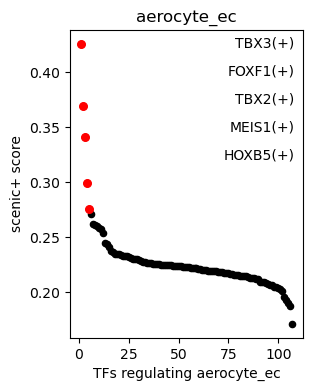

Index(['FOXF1(+)', 'TBX3(+)', 'SP6(+)', 'HOXA5(+)', 'MEIS1(+)'], dtype='object', name='Unnamed: 0')


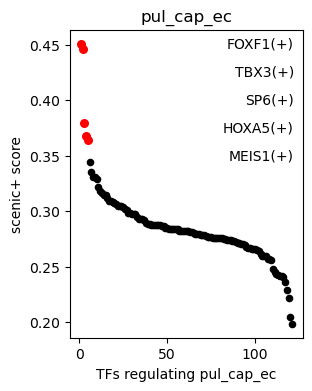

Index(['SMAD1(+)', 'HOXA5(+)', 'ZBED1(+)', 'MAFK(+)', 'MAFB(+)'], dtype='object', name='Unnamed: 0')


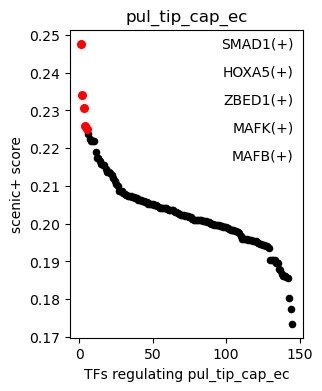

Index(['MAF(+)', 'NR2F1(+)', 'GATA4(+)', 'PRDM1(+)', 'KLF6(+)'], dtype='object', name='Unnamed: 0')


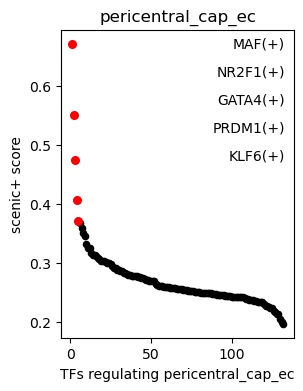

Index(['RFX2(+)', 'NR2F1(+)', 'GATA4(+)', 'PRDM1(+)', 'NFATC1(+)'], dtype='object', name='Unnamed: 0')


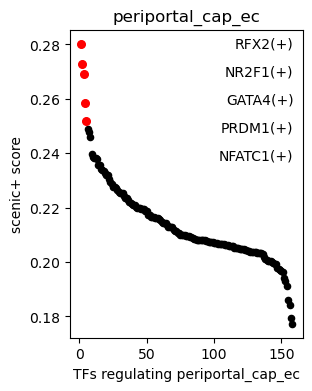

Index(['RARB(+)', 'PBX1(+)', 'MAFB(+)', 'GATA5(+)', 'HIVEP3(+)'], dtype='object', name='Unnamed: 0')


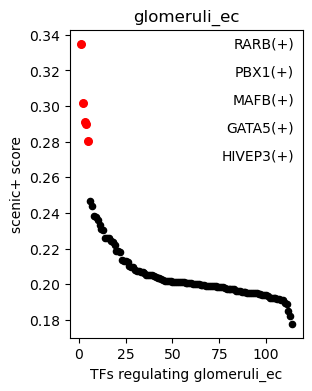

Index(['HOXD9(+)', 'HOXD10(+)', 'HOXD3(+)', 'HOXD8(+)', 'LEF1(+)'], dtype='object', name='Unnamed: 0')


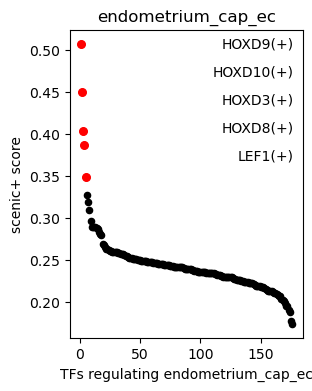

Index(['CREB3L1(+)', 'GATA3(+)', 'FOXN3(+)', 'CREB5(+)', 'MEOX2(+)'], dtype='object', name='Unnamed: 0')


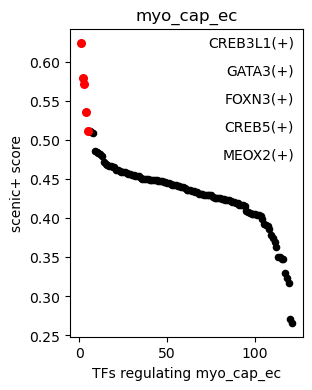

Index(['NR1H3(+)', 'ZNF275(+)', 'PPARG(+)', 'MXD4(+)', 'ZNF354B(+)'], dtype='object', name='Unnamed: 0')


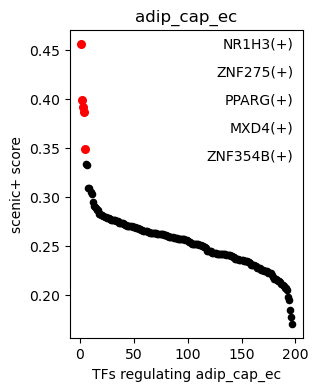

Index(['ARNT2(+)', 'SOX5(+)', 'RFX3(+)', 'LEF1(+)', 'RFX7(+)'], dtype='object', name='Unnamed: 0')


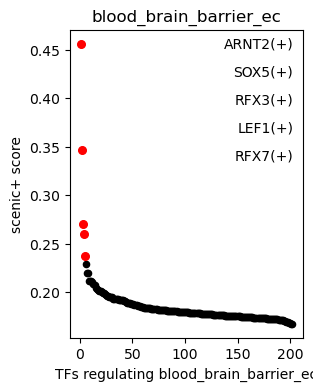

In [38]:
for column_name in rss.columns:
    # Get the values for the specific column (cell type)
    temp = rss[rss.index.isin(filtered_rss[column_name])]
    values = temp[column_name]
    sorted_values = values.sort_values(ascending=False)
    
    # showing top 5 TFs
    top_5_values = sorted_values.head(5)
    top_5_indices = top_5_values.index
    print(top_5_indices)
    
    # plot the scatter plot for all values and top TFs
    plt.figure(figsize=(3, 4))  # Set the figure size
    plt.scatter(range(1, len(values) + 1), sorted_values, color = 'black', label=column_name, s = 20) # Plot all TF values
    plt.scatter(range(1,6), top_5_values, color='red', marker='o', s=30) # Plot the top TF values and highlight in another colour
    
    #for i, txt in enumerate(top_5_indices):
    #    plt.annotate(txt, (i + 10, top_5_values.iloc[i]), ha='left', va='center')
    value_range = max(sorted_values) - min(sorted_values)
    label_interval = value_range / 10
    label_y_positions = [max(sorted_values) - i * label_interval for i in range(len(top_5_indices))]
    
    for i, label in enumerate(top_5_indices):
        plt.text(len(values) + 1, label_y_positions[i], label, ha='right', va='center')
    
    plt.xlabel('TFs regulating {}'.format(column_name))
    plt.ylabel('scenic+ score')
    plt.title(column_name)
    plt.grid(False)
    
    plt.savefig('top_5_TFs_cap_{}.png'.format(column_name), bbox_inches = 'tight', pad_inches = 0.1)
 
    plt.show()

# DE TFs for each compartment

In [40]:
DE_TFs = {}

for cell_type in rss.columns:
    TF_genes = filtered_rss[cell_type]
    TF_genes = [TF[:-3] for TF in TF_genes]
    ad_TFs = ad[:, TF_genes]
    
    sc.tl.rank_genes_groups(ad_TFs, groupby='ann_vas_scenic', use_raw=False)
    sc.tl.filter_rank_genes_groups(ad_TFs, 
                                   groupby='ann_vas_scenic', 
                                   key_added="ranked_TFs_filtered",
                                   min_in_group_fraction=0.1, 
                                   min_fold_change=1,
                                   max_out_group_fraction=0.25, 
                                   use_raw=False)
    
    result = ad_TFs.uns['ranked_TFs_filtered']
    groups = result['names'].dtype.names
    df = pd.DataFrame({group + '_' + key[:1]: result[key][group]
                   for group in groups for key in ['names','pvals_adj','logfoldchanges']})
    
    # Store the TF list in the DE_TFs dictionary with the cell type name as the key
    DE_TFs[cell_type] = df[cell_type + '_n'].unique()
    

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [41]:
DE_TFs

{'aerocyte_ec': array(['TBX3', 'FOXF1', 'TBX2', nan, 'MEIS1', 'CEBPB', 'HOXB5'],
       dtype=object),
 'pul_cap_ec': array(['FOXF1', nan, 'TBX3', 'HOXA5', 'SP6', 'RELB', 'NFATC1', 'MEIS1'],
       dtype=object),
 'pul_tip_cap_ec': array([nan, 'SMAD1', 'FOXF1', 'HOXA5', 'RELB', 'ETV6', 'MEIS1', 'ATF7',
        'ZBED1'], dtype=object),
 'pericentral_cap_ec': array(['NR2F1', 'MAF', nan, 'NR2F2', 'CREM', 'CEBPB', 'GATA4', 'PRDM1',
        'GATA6', 'RARB', 'ELK1', 'MEIS1'], dtype=object),
 'periportal_cap_ec': array([nan, 'CREM', 'NFATC1', 'NR2F1', 'EGR3', 'REL', 'NR2F2', 'CEBPB',
        'FOXO1', 'MAF', 'GATA4', 'RFX2', 'FOXN2', 'TGIF1', 'PRDM1',
        'NFATC2', 'EGR2', 'FOSL1', 'GATA6'], dtype=object),
 'glomeruli_ec': array(['CEBPB', nan, 'PBX1', 'GATA5', 'MAFB', 'HMBOX1', 'MAF', 'RARB',
        'TBX3', 'PRDM1', 'SATB1', 'HIVEP3', 'HOXB5', 'SMAD9', 'TAL1',
        'TFDP2'], dtype=object),
 'endometrium_cap_ec': array(['HOXD9', nan, 'LEF1', 'HOXD10', 'HOXD8', 'SMAD1', 'CREM', 'TGIF1',


In [42]:
for cell_type, genes in DE_TFs.items():
    # Use a list comprehension to filter out NaN values
    modified_genes = [gene + '(+)' for gene in genes if isinstance(gene, str)]
    # Update the dictionary with the modified genes
    DE_TFs[cell_type] = modified_genes

In [43]:
DE_TFs

{'aerocyte_ec': ['TBX3(+)',
  'FOXF1(+)',
  'TBX2(+)',
  'MEIS1(+)',
  'CEBPB(+)',
  'HOXB5(+)'],
 'pul_cap_ec': ['FOXF1(+)',
  'TBX3(+)',
  'HOXA5(+)',
  'SP6(+)',
  'RELB(+)',
  'NFATC1(+)',
  'MEIS1(+)'],
 'pul_tip_cap_ec': ['SMAD1(+)',
  'FOXF1(+)',
  'HOXA5(+)',
  'RELB(+)',
  'ETV6(+)',
  'MEIS1(+)',
  'ATF7(+)',
  'ZBED1(+)'],
 'pericentral_cap_ec': ['NR2F1(+)',
  'MAF(+)',
  'NR2F2(+)',
  'CREM(+)',
  'CEBPB(+)',
  'GATA4(+)',
  'PRDM1(+)',
  'GATA6(+)',
  'RARB(+)',
  'ELK1(+)',
  'MEIS1(+)'],
 'periportal_cap_ec': ['CREM(+)',
  'NFATC1(+)',
  'NR2F1(+)',
  'EGR3(+)',
  'REL(+)',
  'NR2F2(+)',
  'CEBPB(+)',
  'FOXO1(+)',
  'MAF(+)',
  'GATA4(+)',
  'RFX2(+)',
  'FOXN2(+)',
  'TGIF1(+)',
  'PRDM1(+)',
  'NFATC2(+)',
  'EGR2(+)',
  'FOSL1(+)',
  'GATA6(+)'],
 'glomeruli_ec': ['CEBPB(+)',
  'PBX1(+)',
  'GATA5(+)',
  'MAFB(+)',
  'HMBOX1(+)',
  'MAF(+)',
  'RARB(+)',
  'TBX3(+)',
  'PRDM1(+)',
  'SATB1(+)',
  'HIVEP3(+)',
  'HOXB5(+)',
  'SMAD9(+)',
  'TAL1(+)',
  'TFDP2(+)'],
 '

In [44]:
count_dict = {}

# Iterate through each cell type and its associated TFs
for cell_type, tfs in DE_TFs.items():
    # Initialize a dictionary for this cell type
    cell_type_counts = {}
    
    # Iterate through the TFs for this cell type
    for tf in tfs:
        # Count the number of genes for this TF from regulons_comp
        num_genes = len(regulons.get(tf, []))
        
        # Add the TF and its count to the cell_type_counts dictionary
        cell_type_counts[tf] = num_genes
    
    # Add the cell_type_counts dictionary to the count_dict
    count_dict[cell_type] = cell_type_counts

# Print the count_dict
for cell_type, tf_counts in count_dict.items():
    print(cell_type, tf_counts, '\n')

aerocyte_ec {'TBX3(+)': 16, 'FOXF1(+)': 63, 'TBX2(+)': 100, 'MEIS1(+)': 201, 'CEBPB(+)': 949, 'HOXB5(+)': 154} 

pul_cap_ec {'FOXF1(+)': 63, 'TBX3(+)': 16, 'HOXA5(+)': 228, 'SP6(+)': 416, 'RELB(+)': 791, 'NFATC1(+)': 145, 'MEIS1(+)': 201} 

pul_tip_cap_ec {'SMAD1(+)': 89, 'FOXF1(+)': 63, 'HOXA5(+)': 228, 'RELB(+)': 791, 'ETV6(+)': 1350, 'MEIS1(+)': 201, 'ATF7(+)': 71, 'ZBED1(+)': 55} 

pericentral_cap_ec {'NR2F1(+)': 67, 'MAF(+)': 14, 'NR2F2(+)': 265, 'CREM(+)': 1117, 'CEBPB(+)': 949, 'GATA4(+)': 243, 'PRDM1(+)': 54, 'GATA6(+)': 288, 'RARB(+)': 22, 'ELK1(+)': 348, 'MEIS1(+)': 201} 

periportal_cap_ec {'CREM(+)': 1117, 'NFATC1(+)': 145, 'NR2F1(+)': 67, 'EGR3(+)': 566, 'REL(+)': 474, 'NR2F2(+)': 265, 'CEBPB(+)': 949, 'FOXO1(+)': 65, 'MAF(+)': 14, 'GATA4(+)': 243, 'RFX2(+)': 34, 'FOXN2(+)': 115, 'TGIF1(+)': 37, 'PRDM1(+)': 54, 'NFATC2(+)': 49, 'EGR2(+)': 117, 'FOSL1(+)': 711, 'GATA6(+)': 288} 

glomeruli_ec {'CEBPB(+)': 949, 'PBX1(+)': 48, 'GATA5(+)': 65, 'MAFB(+)': 16, 'HMBOX1(+)': 13, '

# pericentral_cap_ec

In [46]:
cell_type_of_interest = 'pericentral_cap_ec'

In [47]:
DE_TFs[cell_type_of_interest]

['NR2F1(+)',
 'MAF(+)',
 'NR2F2(+)',
 'CREM(+)',
 'CEBPB(+)',
 'GATA4(+)',
 'PRDM1(+)',
 'GATA6(+)',
 'RARB(+)',
 'ELK1(+)',
 'MEIS1(+)']

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


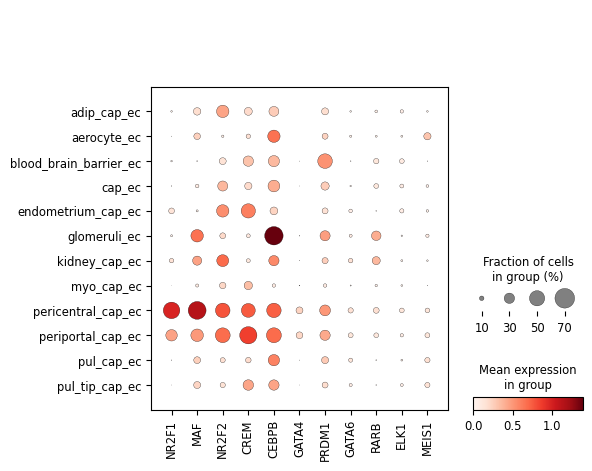

In [48]:
sc.pl.dotplot(ad, [TF[:-3] for TF in DE_TFs[cell_type_of_interest]], groupby = 'ann_vas_scenic')

In [49]:
temp = rss[rss.index.isin(filtered_rss[cell_type_of_interest])]
temp[cell_type_of_interest].sort_values(ascending=False).head(15)

Unnamed: 0
MAF(+)       0.671078
NR2F1(+)     0.550665
GATA4(+)     0.474758
PRDM1(+)     0.405966
KLF6(+)      0.371596
TAL1(+)      0.368108
GATA6(+)     0.359202
NR2F2(+)     0.351420
TBPL1(+)     0.345993
TCF7L1(+)    0.332188
HES1(+)      0.326126
CREM(+)      0.324953
ELF1(+)      0.316556
FOSB(+)      0.313518
ELK1(+)      0.313206
Name: pericentral_cap_ec, dtype: float64

In [51]:
temp[cell_type_of_interest].sort_values(ascending=False).head(4).index # RELB(+)

Index(['MAF(+)', 'NR2F1(+)', 'GATA4(+)', 'PRDM1(+)'], dtype='object', name='Unnamed: 0')

In [53]:
TFs_of_interest = ['GATA4(+)', 'NFATC1(+)', 'FOXN2(+)', 'EGR2(+)']

target_genes_union = set()

for TF in TFs_of_interest:
    target_genes_union.update(regulons.get(TF, []))
    
target_genes_list = list(target_genes_union)

inter_target_gene = set(DE_gene[cell_type_of_interest+'_n']).intersection(set(target_genes_list))

In [54]:
TFs_of_interest = ['GATA4(+)', 'NFATC1(+)', 'FOXN2(+)', 'EGR2(+)']
for TF in TFs_of_interest:
    print(TF,':',set(inter_target_gene).intersection(set(regulons[TF])))

GATA4(+) : {'MS4A6A', 'MID1', 'CD4', 'NPL', 'TGFBR3', 'TBC1D4', 'FEZ1', 'SC5D', 'IGF2BP2', 'CFP', 'CLEC4M', 'GPR182', 'PVALB', 'MRC1', 'MRO', 'NRP2', 'RGL1', 'SNX5', 'C1QTNF1', 'ALDH1A1', 'WIPI1', 'C7', 'CD14', 'FAM107B', 'NR2F1', 'NPY1R', 'GPM6A', 'DNM3OS', 'ZEB2', 'ART4', 'RASGEF1B', 'SLC40A1', 'FCN2', 'F2R', 'ANPEP', 'PLAC8', 'ST6GAL1', 'FCGR2B', 'OIT3', 'ADM', 'IL33', 'SNX2', 'STAB2', 'MAF', 'VMO1', 'CLEC4G', 'CRHBP', 'DNASE1L3', 'BMPER', 'EMILIN1', 'NT5E', 'EPOR', 'USP13', 'PLTP', 'NID1', 'CLEC1B', 'STAB1', 'LYVE1', 'ADAMTS4'}
NFATC1(+) : {'ZEB2', 'BMPER'}
FOXN2(+) : {'TGFBR3', 'RASGEF1B', 'MID1', 'RGL1'}
EGR2(+) : {'SLC40A1', 'FAM107B'}


In [56]:
TFs_of_interest = ['GATA4(+)', 'NFATC1(+)', 'FOXN2(+)', 'EGR2(+)'] #, 'HAND2(+)'

# Initialize an empty list to store the pairs
pairs = []

# Iterate through TFs of interest and their intersection sets
for TF in TFs_of_interest:
    intersection_set = set(inter_target_gene).intersection(set(regulons[TF]))
    for gene in intersection_set:
        pairs.append((TF, gene))

# Print the list of pairs
pairs # + [('IRX3(+)', 'IRX3')]

[('GATA4(+)', 'MS4A6A'),
 ('GATA4(+)', 'MID1'),
 ('GATA4(+)', 'CD4'),
 ('GATA4(+)', 'NPL'),
 ('GATA4(+)', 'TGFBR3'),
 ('GATA4(+)', 'TBC1D4'),
 ('GATA4(+)', 'FEZ1'),
 ('GATA4(+)', 'SC5D'),
 ('GATA4(+)', 'IGF2BP2'),
 ('GATA4(+)', 'CFP'),
 ('GATA4(+)', 'CLEC4M'),
 ('GATA4(+)', 'GPR182'),
 ('GATA4(+)', 'PVALB'),
 ('GATA4(+)', 'MRC1'),
 ('GATA4(+)', 'MRO'),
 ('GATA4(+)', 'NRP2'),
 ('GATA4(+)', 'RGL1'),
 ('GATA4(+)', 'SNX5'),
 ('GATA4(+)', 'C1QTNF1'),
 ('GATA4(+)', 'ALDH1A1'),
 ('GATA4(+)', 'WIPI1'),
 ('GATA4(+)', 'C7'),
 ('GATA4(+)', 'CD14'),
 ('GATA4(+)', 'FAM107B'),
 ('GATA4(+)', 'NR2F1'),
 ('GATA4(+)', 'NPY1R'),
 ('GATA4(+)', 'GPM6A'),
 ('GATA4(+)', 'DNM3OS'),
 ('GATA4(+)', 'ZEB2'),
 ('GATA4(+)', 'ART4'),
 ('GATA4(+)', 'RASGEF1B'),
 ('GATA4(+)', 'SLC40A1'),
 ('GATA4(+)', 'FCN2'),
 ('GATA4(+)', 'F2R'),
 ('GATA4(+)', 'ANPEP'),
 ('GATA4(+)', 'PLAC8'),
 ('GATA4(+)', 'ST6GAL1'),
 ('GATA4(+)', 'FCGR2B'),
 ('GATA4(+)', 'OIT3'),
 ('GATA4(+)', 'ADM'),
 ('GATA4(+)', 'IL33'),
 ('GATA4(+)', 'SNX2'),

In [57]:
G = nx.Graph()
G.clear()
G.add_edges_from(pairs + [('FOXN2(+)', 'FOXN2')])

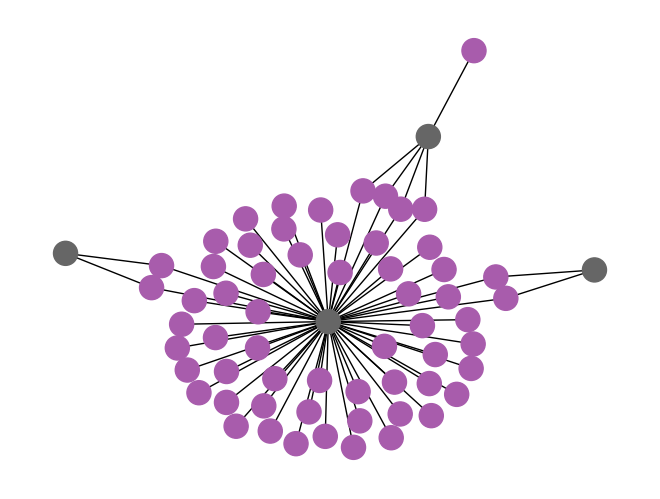

In [58]:
options = {
    "node_color": ["#666666" if '(+)' in gene else 
                   "#a85cac" for gene in list(G.nodes)],
    # "width": 2,
    # "node_size":500
    }
nx.draw(G, # with_labels=True,
       **options)
plt.show()

# periportal_cap_ec

In [59]:
cell_type_of_interest = 'periportal_cap_ec'

In [60]:
DE_TFs[cell_type_of_interest]

['CREM(+)',
 'NFATC1(+)',
 'NR2F1(+)',
 'EGR3(+)',
 'REL(+)',
 'NR2F2(+)',
 'CEBPB(+)',
 'FOXO1(+)',
 'MAF(+)',
 'GATA4(+)',
 'RFX2(+)',
 'FOXN2(+)',
 'TGIF1(+)',
 'PRDM1(+)',
 'NFATC2(+)',
 'EGR2(+)',
 'FOSL1(+)',
 'GATA6(+)']

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


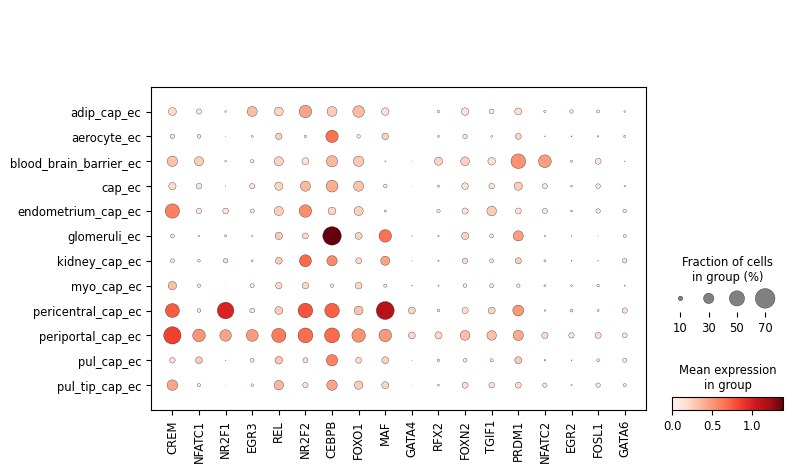

In [61]:
sc.pl.dotplot(ad, [TF[:-3] for TF in DE_TFs[cell_type_of_interest]], groupby = 'ann_vas_scenic')

In [62]:
temp = rss[rss.index.isin(filtered_rss[cell_type_of_interest])]
temp[cell_type_of_interest].sort_values(ascending=False).head(15)


Unnamed: 0
RFX2(+)      0.280321
NR2F1(+)     0.272906
GATA4(+)     0.269167
PRDM1(+)     0.258446
NFATC1(+)    0.251706
MEF2C(+)     0.248823
KLF6(+)      0.247862
EGR2(+)      0.246043
FOXN2(+)     0.239637
TGIF1(+)     0.238751
MAF(+)       0.238359
FOSB(+)      0.238125
NR2F2(+)     0.237752
REL(+)       0.235733
CREM(+)      0.235483
Name: periportal_cap_ec, dtype: float64

In [64]:
temp[cell_type_of_interest].sort_values(ascending=False).head(3).index # RELB(+)

Index(['RFX2(+)', 'NR2F1(+)', 'GATA4(+)'], dtype='object', name='Unnamed: 0')

In [66]:
TFs_of_interest = ['NR2F1(+)', 'MAF(+)', 'GATA4(+)']

target_genes_union = set()

for TF in TFs_of_interest:
    target_genes_union.update(regulons.get(TF, []))
    
target_genes_list = list(target_genes_union)

inter_target_gene = set(DE_gene[cell_type_of_interest+'_n']).intersection(set(target_genes_list))

In [67]:
TFs_of_interest = ['NR2F1(+)', 'MAF(+)', 'GATA4(+)']
for TF in TFs_of_interest:
    print(TF,':',set(inter_target_gene).intersection(set(regulons[TF])))

NR2F1(+) : {'CD4', 'CFP', 'RBP1', 'NTN4', 'RGL1', 'ALDH1A1', 'C7', 'FAM107B', 'NR2F1', 'GPM6A', 'ZEB2', 'SLC40A1', 'IL33', 'OIT3', 'ADAMTS4', 'BMPER', 'CLEC1B', 'MEG3', 'ACP5'}
MAF(+) : {'MRC1', 'CLEC1B', 'LYVE1', 'CD4'}
GATA4(+) : {'MS4A6A', 'CD4', 'FEZ1', 'RFK', 'SC5D', 'CFP', 'CLEC4M', 'MRC1', 'RGL1', 'ALDH1A1', 'C7', 'FAM107B', 'NR2F1', 'FRMD4B', 'GPM6A', 'FILIP1', 'ZEB2', 'ART4', 'PDE4B', 'RASGEF1B', 'SLC40A1', 'FCN2', 'F2R', 'PLAC8', 'IL33', 'OIT3', 'VMO1', 'CLEC4G', 'CRHBP', 'NOVA1', 'GNA14', 'DNASE1L3', 'BMPER', 'CLEC1B', 'TRAF6', 'LYVE1', 'ADAMTS4'}


In [69]:
TFs_of_interest = ['NR2F1(+)', 'MAF(+)', 'GATA4(+)'] #, 'HAND2(+)'

# Initialize an empty list to store the pairs
pairs = []

# Iterate through TFs of interest and their intersection sets
for TF in TFs_of_interest:
    intersection_set = set(inter_target_gene).intersection(set(regulons[TF]))
    for gene in intersection_set:
        pairs.append((TF, gene))

# Print the list of pairs
pairs # + [('IRX3(+)', 'IRX3')]

[('NR2F1(+)', 'CD4'),
 ('NR2F1(+)', 'CFP'),
 ('NR2F1(+)', 'RBP1'),
 ('NR2F1(+)', 'NTN4'),
 ('NR2F1(+)', 'RGL1'),
 ('NR2F1(+)', 'ALDH1A1'),
 ('NR2F1(+)', 'C7'),
 ('NR2F1(+)', 'FAM107B'),
 ('NR2F1(+)', 'NR2F1'),
 ('NR2F1(+)', 'GPM6A'),
 ('NR2F1(+)', 'ZEB2'),
 ('NR2F1(+)', 'SLC40A1'),
 ('NR2F1(+)', 'IL33'),
 ('NR2F1(+)', 'OIT3'),
 ('NR2F1(+)', 'ADAMTS4'),
 ('NR2F1(+)', 'BMPER'),
 ('NR2F1(+)', 'CLEC1B'),
 ('NR2F1(+)', 'MEG3'),
 ('NR2F1(+)', 'ACP5'),
 ('MAF(+)', 'MRC1'),
 ('MAF(+)', 'CLEC1B'),
 ('MAF(+)', 'LYVE1'),
 ('MAF(+)', 'CD4'),
 ('GATA4(+)', 'MS4A6A'),
 ('GATA4(+)', 'CD4'),
 ('GATA4(+)', 'FEZ1'),
 ('GATA4(+)', 'RFK'),
 ('GATA4(+)', 'SC5D'),
 ('GATA4(+)', 'CFP'),
 ('GATA4(+)', 'CLEC4M'),
 ('GATA4(+)', 'MRC1'),
 ('GATA4(+)', 'RGL1'),
 ('GATA4(+)', 'ALDH1A1'),
 ('GATA4(+)', 'C7'),
 ('GATA4(+)', 'FAM107B'),
 ('GATA4(+)', 'NR2F1'),
 ('GATA4(+)', 'FRMD4B'),
 ('GATA4(+)', 'GPM6A'),
 ('GATA4(+)', 'FILIP1'),
 ('GATA4(+)', 'ZEB2'),
 ('GATA4(+)', 'ART4'),
 ('GATA4(+)', 'PDE4B'),
 ('GATA4(+)', '

In [70]:
G = nx.Graph()
G.clear()
G.add_edges_from(pairs + [('MAF(+)', 'MAF')])

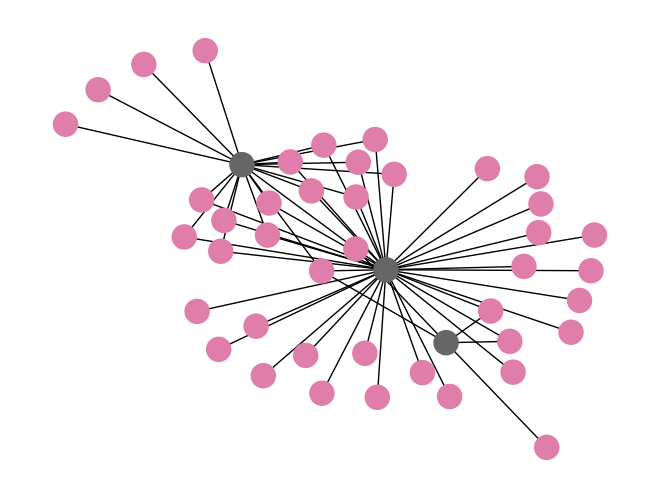

In [71]:
options = {
    "node_color": ["#666666" if '(+)' in gene else 
                   "#e07eab" for gene in list(G.nodes)],
    # "width": 2,
    # "node_size":500
    }
nx.draw(G, # with_labels=True,
       **options)
plt.show()

## LSEC

In [63]:
import pandas as pd
rss = pd.read_csv('./rss_T.csv')
rss.set_index('Unnamed: 0', inplace=True)
rss

,aerocyte_ec,pul_cap_ec,pul_tip_cap_ec,pericentral_cap_ec,periportal_cap_ec,glomeruli_ec,endometrium_cap_ec,myo_cap_ec,adip_cap_ec,blood_brain_barrier_ec
Unnamed: 0,,,,,,,,,,
ARID3A(+),0.312913,0.338536,0.197379,0.232387,0.201412,0.199915,0.255548,0.332581,0.225421,0.194678
ARNT(+),0.219987,0.271690,0.197401,0.271590,0.210467,0.200223,0.234502,0.437707,0.259402,0.191528
ARNT2(+),0.181267,0.214185,0.176044,0.235011,0.191048,0.204219,0.176118,0.268214,0.205739,0.456133
ARNTL(+),0.209033,0.237597,0.196880,0.245734,0.205624,0.195701,0.229009,0.404272,0.258804,0.180024
ARNTL2(+),0.203316,0.267859,0.209008,0.234810,0.209889,0.189678,0.264923,0.379812,0.245813,0.184914
...,...,...,...,...,...,...,...,...,...,...
ZNF91(+),0.225899,0.273829,0.197343,0.247993,0.206668,0.213110,0.233691,0.439826,0.268547,0.191790
ZSCAN1(+),0.196674,0.231558,0.198939,0.231501,0.212809,0.194723,0.252751,0.355535,0.253584,0.199492
ZSCAN23(+),0.187207,0.210349,0.228480,0.182571,0.176990,0.193956,0.188272,0.362052,0.218115,0.177681


In [64]:
rss.loc[['EGR2(+)','NR2F1(+)']]

,aerocyte_ec,pul_cap_ec,pul_tip_cap_ec,pericentral_cap_ec,periportal_cap_ec,glomeruli_ec,endometrium_cap_ec,myo_cap_ec,adip_cap_ec,blood_brain_barrier_ec
Unnamed: 0,,,,,,,,,,
EGR2(+),0.203944,0.260675,0.201512,0.304151,0.246043,0.195405,0.249990,0.401675,0.254759,0.179353
NR2F1(+),0.186151,0.222217,0.181584,0.550665,0.272906,0.208586,0.224697,0.257109,0.189462,0.174292


In [69]:
rss[rss.index.isin(filtered_rss['pericentral_cap_ec'])]

,aerocyte_ec,pul_cap_ec,pul_tip_cap_ec,pericentral_cap_ec,periportal_cap_ec,glomeruli_ec,endometrium_cap_ec,myo_cap_ec,adip_cap_ec,blood_brain_barrier_ec
Unnamed: 0,,,,,,,,,,
ARNT(+),0.219987,0.271690,0.197401,0.271590,0.210467,0.200223,0.234502,0.437707,0.259402,0.191528
ATF1(+),0.219366,0.271228,0.202212,0.261009,0.216400,0.196598,0.259764,0.448625,0.236085,0.175875
ATF2(+),0.213053,0.275562,0.202181,0.256362,0.214298,0.199099,0.228951,0.448862,0.265005,0.195307
ATF3(+),0.217242,0.298001,0.213609,0.291050,0.223380,0.197175,0.233974,0.426493,0.248536,0.174587
ATF4(+),0.211813,0.271195,0.199883,0.260334,0.216178,0.194763,0.239179,0.459373,0.279247,0.172442
...,...,...,...,...,...,...,...,...,...,...
ZBTB16(+),0.233465,0.293075,0.195924,0.248934,0.209416,0.243827,0.207324,0.374529,0.281675,0.229208
ZBTB7A(+),0.219646,0.276789,0.200601,0.242533,0.203621,0.195517,0.229605,0.456142,0.280996,0.182147
ZEB1(+),0.222761,0.283486,0.203236,0.241130,0.204824,0.207407,0.229245,0.443306,0.270243,0.199429


In [70]:
rss[rss.index.isin(filtered_rss['periportal_cap_ec'])]

,aerocyte_ec,pul_cap_ec,pul_tip_cap_ec,pericentral_cap_ec,periportal_cap_ec,glomeruli_ec,endometrium_cap_ec,myo_cap_ec,adip_cap_ec,blood_brain_barrier_ec
Unnamed: 0,,,,,,,,,,
ARNT(+),0.219987,0.271690,0.197401,0.271590,0.210467,0.200223,0.234502,0.437707,0.259402,0.191528
ATF1(+),0.219366,0.271228,0.202212,0.261009,0.216400,0.196598,0.259764,0.448625,0.236085,0.175875
ATF2(+),0.213053,0.275562,0.202181,0.256362,0.214298,0.199099,0.228951,0.448862,0.265005,0.195307
ATF3(+),0.217242,0.298001,0.213609,0.291050,0.223380,0.197175,0.233974,0.426493,0.248536,0.174587
ATF4(+),0.211813,0.271195,0.199883,0.260334,0.216178,0.194763,0.239179,0.459373,0.279247,0.172442
...,...,...,...,...,...,...,...,...,...,...
ZEB1(+),0.222761,0.283486,0.203236,0.241130,0.204824,0.207407,0.229245,0.443306,0.270243,0.199429
ZFX(+),0.222859,0.273758,0.199531,0.250417,0.208836,0.199700,0.234237,0.435605,0.273134,0.192358
ZNF121(+),0.210889,0.242008,0.187365,0.222042,0.204324,0.193968,0.223847,0.343200,0.242758,0.178397


In [71]:
pc = rss[rss.index.isin(filtered_rss['pericentral_cap_ec'])]
pc = pc[['pericentral_cap_ec','periportal_cap_ec']]
pp = rss[rss.index.isin(filtered_rss['periportal_cap_ec'])]
pp = pp[['pericentral_cap_ec','periportal_cap_ec']]

In [72]:
pc.index

Index(['ARNT(+)', 'ATF1(+)', 'ATF2(+)', 'ATF3(+)', 'ATF4(+)', 'ATF6(+)',
       'ATF6B(+)', 'ATF7(+)', 'BACH1(+)', 'BCL6B(+)',
       ...
       'TFDP2(+)', 'TGIF1(+)', 'USF2(+)', 'XBP1(+)', 'YY1(+)', 'ZBTB16(+)',
       'ZBTB7A(+)', 'ZEB1(+)', 'ZFX(+)', 'ZNF322(+)'],
      dtype='object', name='Unnamed: 0', length=132)

In [73]:
pp.index

Index(['ARNT(+)', 'ATF1(+)', 'ATF2(+)', 'ATF3(+)', 'ATF4(+)', 'ATF6(+)',
       'ATF6B(+)', 'ATF7(+)', 'BACH1(+)', 'BCL6B(+)',
       ...
       'USF2(+)', 'XBP1(+)', 'YY1(+)', 'ZBTB16(+)', 'ZBTB7A(+)', 'ZEB1(+)',
       'ZFX(+)', 'ZNF121(+)', 'ZNF274(+)', 'ZNF322(+)'],
      dtype='object', name='Unnamed: 0', length=158)

In [74]:
# Union of the indices
union_indices = list(set(pc.index).union(set(pp.index)))

# Create a new DataFrame with the union indices

rss_LSEC = pd.DataFrame(index=union_indices)

# Merge data from the original DataFrames into the new DataFrame
rss_LSEC = rss_LSEC.merge(pc, left_index=True, right_index=True, how='left')
rss_LSEC = rss_LSEC.merge(pp, left_index=True, right_index=True, how='left')

# Keep only the desired columns
rss_LSEC = rss_LSEC[['pericentral_cap_ec_x', 'periportal_cap_ec_y']]

# Fill NaN values with appropriate values if needed
rss_LSEC = rss_LSEC.fillna(0.17)  # Fill NaN with 0 as an example
rss_LSEC

,pericentral_cap_ec_x,periportal_cap_ec_y
RARA(+),0.227712,0.203602
ATF6B(+),0.256702,0.209489
DDIT3(+),0.278009,0.196563
MEF2C(+),0.299504,0.248823
KLF3(+),0.242644,0.203489
...,...,...
MAFF(+),0.270076,0.225274
ZNF322(+),0.250873,0.203027
EGR1(+),0.308414,0.232147
FOXJ3(+),0.170000,0.199135


In [75]:
min_pericentral = rss_LSEC['pericentral_cap_ec_x'].min()
max_pericentral = rss_LSEC['pericentral_cap_ec_x'].max()

min_periportal = rss_LSEC['periportal_cap_ec_y'].min()
max_periportal = rss_LSEC['periportal_cap_ec_y'].max()

# Normalize the 'pericentral' column
rss_LSEC['pericentral_norm'] = (rss_LSEC['pericentral_cap_ec_x'] - min_pericentral) / (max_pericentral - min_pericentral)

# Normalize the 'periportal' column
rss_LSEC['periportal_norm'] = (rss_LSEC['periportal_cap_ec_y'] - min_periportal) / (max_periportal - min_periportal)

rss_LSEC

,pericentral_cap_ec_x,periportal_cap_ec_y,pericentral_norm,periportal_norm
RARA(+),0.227712,0.203602,0.115176,0.304587
ATF6B(+),0.256702,0.209489,0.173031,0.357943
DDIT3(+),0.278009,0.196563,0.215554,0.240778
MEF2C(+),0.299504,0.248823,0.258450,0.714491
KLF3(+),0.242644,0.203489,0.144976,0.303559
...,...,...,...,...
MAFF(+),0.270076,0.225274,0.199720,0.501029
ZNF322(+),0.250873,0.203027,0.161399,0.299369
EGR1(+),0.308414,0.232147,0.276233,0.563329
FOXJ3(+),0.170000,0.199135,0.000000,0.264098


In [76]:
min_pericentral = rss_LSEC['pericentral_cap_ec_x'].min()
max_pericentral = rss_LSEC['pericentral_cap_ec_x'].max()

min_periportal = rss_LSEC['periportal_cap_ec_y'].min()
max_periportal = rss_LSEC['periportal_cap_ec_y'].max()

# Normalize the 'pericentral' column
rss_LSEC['pericentral_norm'] = (rss_LSEC['pericentral_cap_ec_x'] - 0) / (max_pericentral - 0)

# Normalize the 'periportal' column
rss_LSEC['periportal_norm'] = (rss_LSEC['periportal_cap_ec_y'] - 0) / (max_periportal - 0)

rss_LSEC

,pericentral_cap_ec_x,periportal_cap_ec_y,pericentral_norm,periportal_norm
RARA(+),0.227712,0.203602,0.339323,0.726319
ATF6B(+),0.256702,0.209489,0.382522,0.747317
DDIT3(+),0.278009,0.196563,0.414272,0.701207
MEF2C(+),0.299504,0.248823,0.446302,0.887637
KLF3(+),0.242644,0.203489,0.361574,0.725914
...,...,...,...,...
MAFF(+),0.270076,0.225274,0.402450,0.803629
ZNF322(+),0.250873,0.203027,0.373836,0.724265
EGR1(+),0.308414,0.232147,0.459580,0.828147
FOXJ3(+),0.170000,0.199135,0.253324,0.710384


In [77]:
rss_LSEC.to_csv('rss_scaled_plot_number.csv')

In [78]:
highlighted_pc_index = ['NR2F1(+)', 'MAF(+)'] #a85cac
highlighted_pp_index = ['NFATC1(+)', 'FOXN2(+)', 'EGR2(+)'] #a85cac
highlighted_lsec_index = ['GATA4(+)'] #a85cac

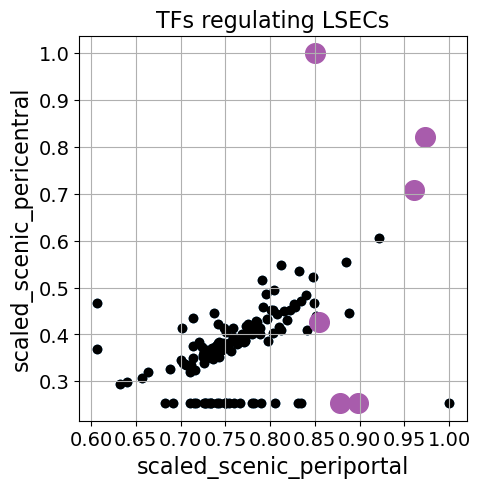

In [79]:
plt.figure(figsize =(5,5))
plt.scatter(rss_LSEC['periportal_norm'], rss_LSEC['pericentral_norm'])

# Black
plt.scatter(rss_LSEC['periportal_norm'], rss_LSEC['pericentral_norm'], color='black')

# Gray
gray_condition = (rss_LSEC['pericentral_norm'] == 0) | (rss_LSEC['periportal_norm'] == 0)
gray_data = rss_LSEC[gray_condition]
plt.scatter(gray_data['periportal_norm'], gray_data['pericentral_norm'], color='gray')

# pc
highlighted_pc = rss_LSEC.loc[rss_LSEC.index.isin(highlighted_pc_index)]
plt.scatter(highlighted_pc['periportal_norm'], highlighted_pc['pericentral_norm'], 
            color='#a85cac', s = 200
)

# pp
highlighted_pp = rss_LSEC.loc[rss_LSEC.index.isin(highlighted_pp_index)]
plt.scatter(highlighted_pp['periportal_norm'], highlighted_pp['pericentral_norm'], 
            color='#a85cac', s = 200
)

# GATA4
highlighted_lsec = rss_LSEC.loc[rss_LSEC.index.isin(highlighted_lsec_index)]
plt.scatter(highlighted_lsec['periportal_norm'], highlighted_lsec['pericentral_norm'], 
            color='#a85cac', s = 200
)

# Add labels, legend, and other plot customizations

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('scaled_scenic_periportal', fontsize = 16)
plt.ylabel('scaled_scenic_pericentral', fontsize = 16)

plt.title('TFs regulating LSECs', fontsize = 16)
plt.grid(True)

# Show the plot
plt.savefig('./figures/scatter_LSEC_scale.png', bbox_inches='tight', pad_inches=0.2)
plt.show()

In [80]:
rss_LSEC.to_csv('rss_scaled_plot_number.csv')

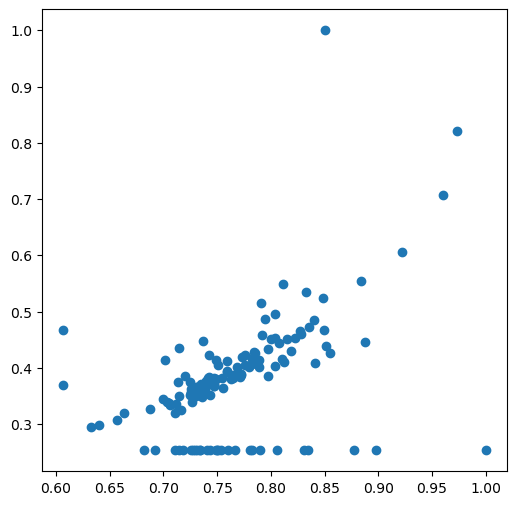

In [81]:
plt.figure(figsize =(6,6))
plt.scatter(rss_LSEC['periportal_norm'], rss_LSEC['pericentral_norm'])

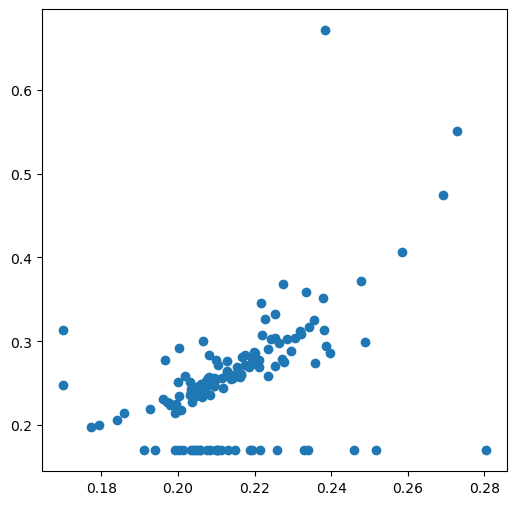

In [82]:
plt.figure(figsize =(6,6))
plt.scatter(rss_LSEC['periportal_cap_ec_y'], rss_LSEC['pericentral_cap_ec_x'])

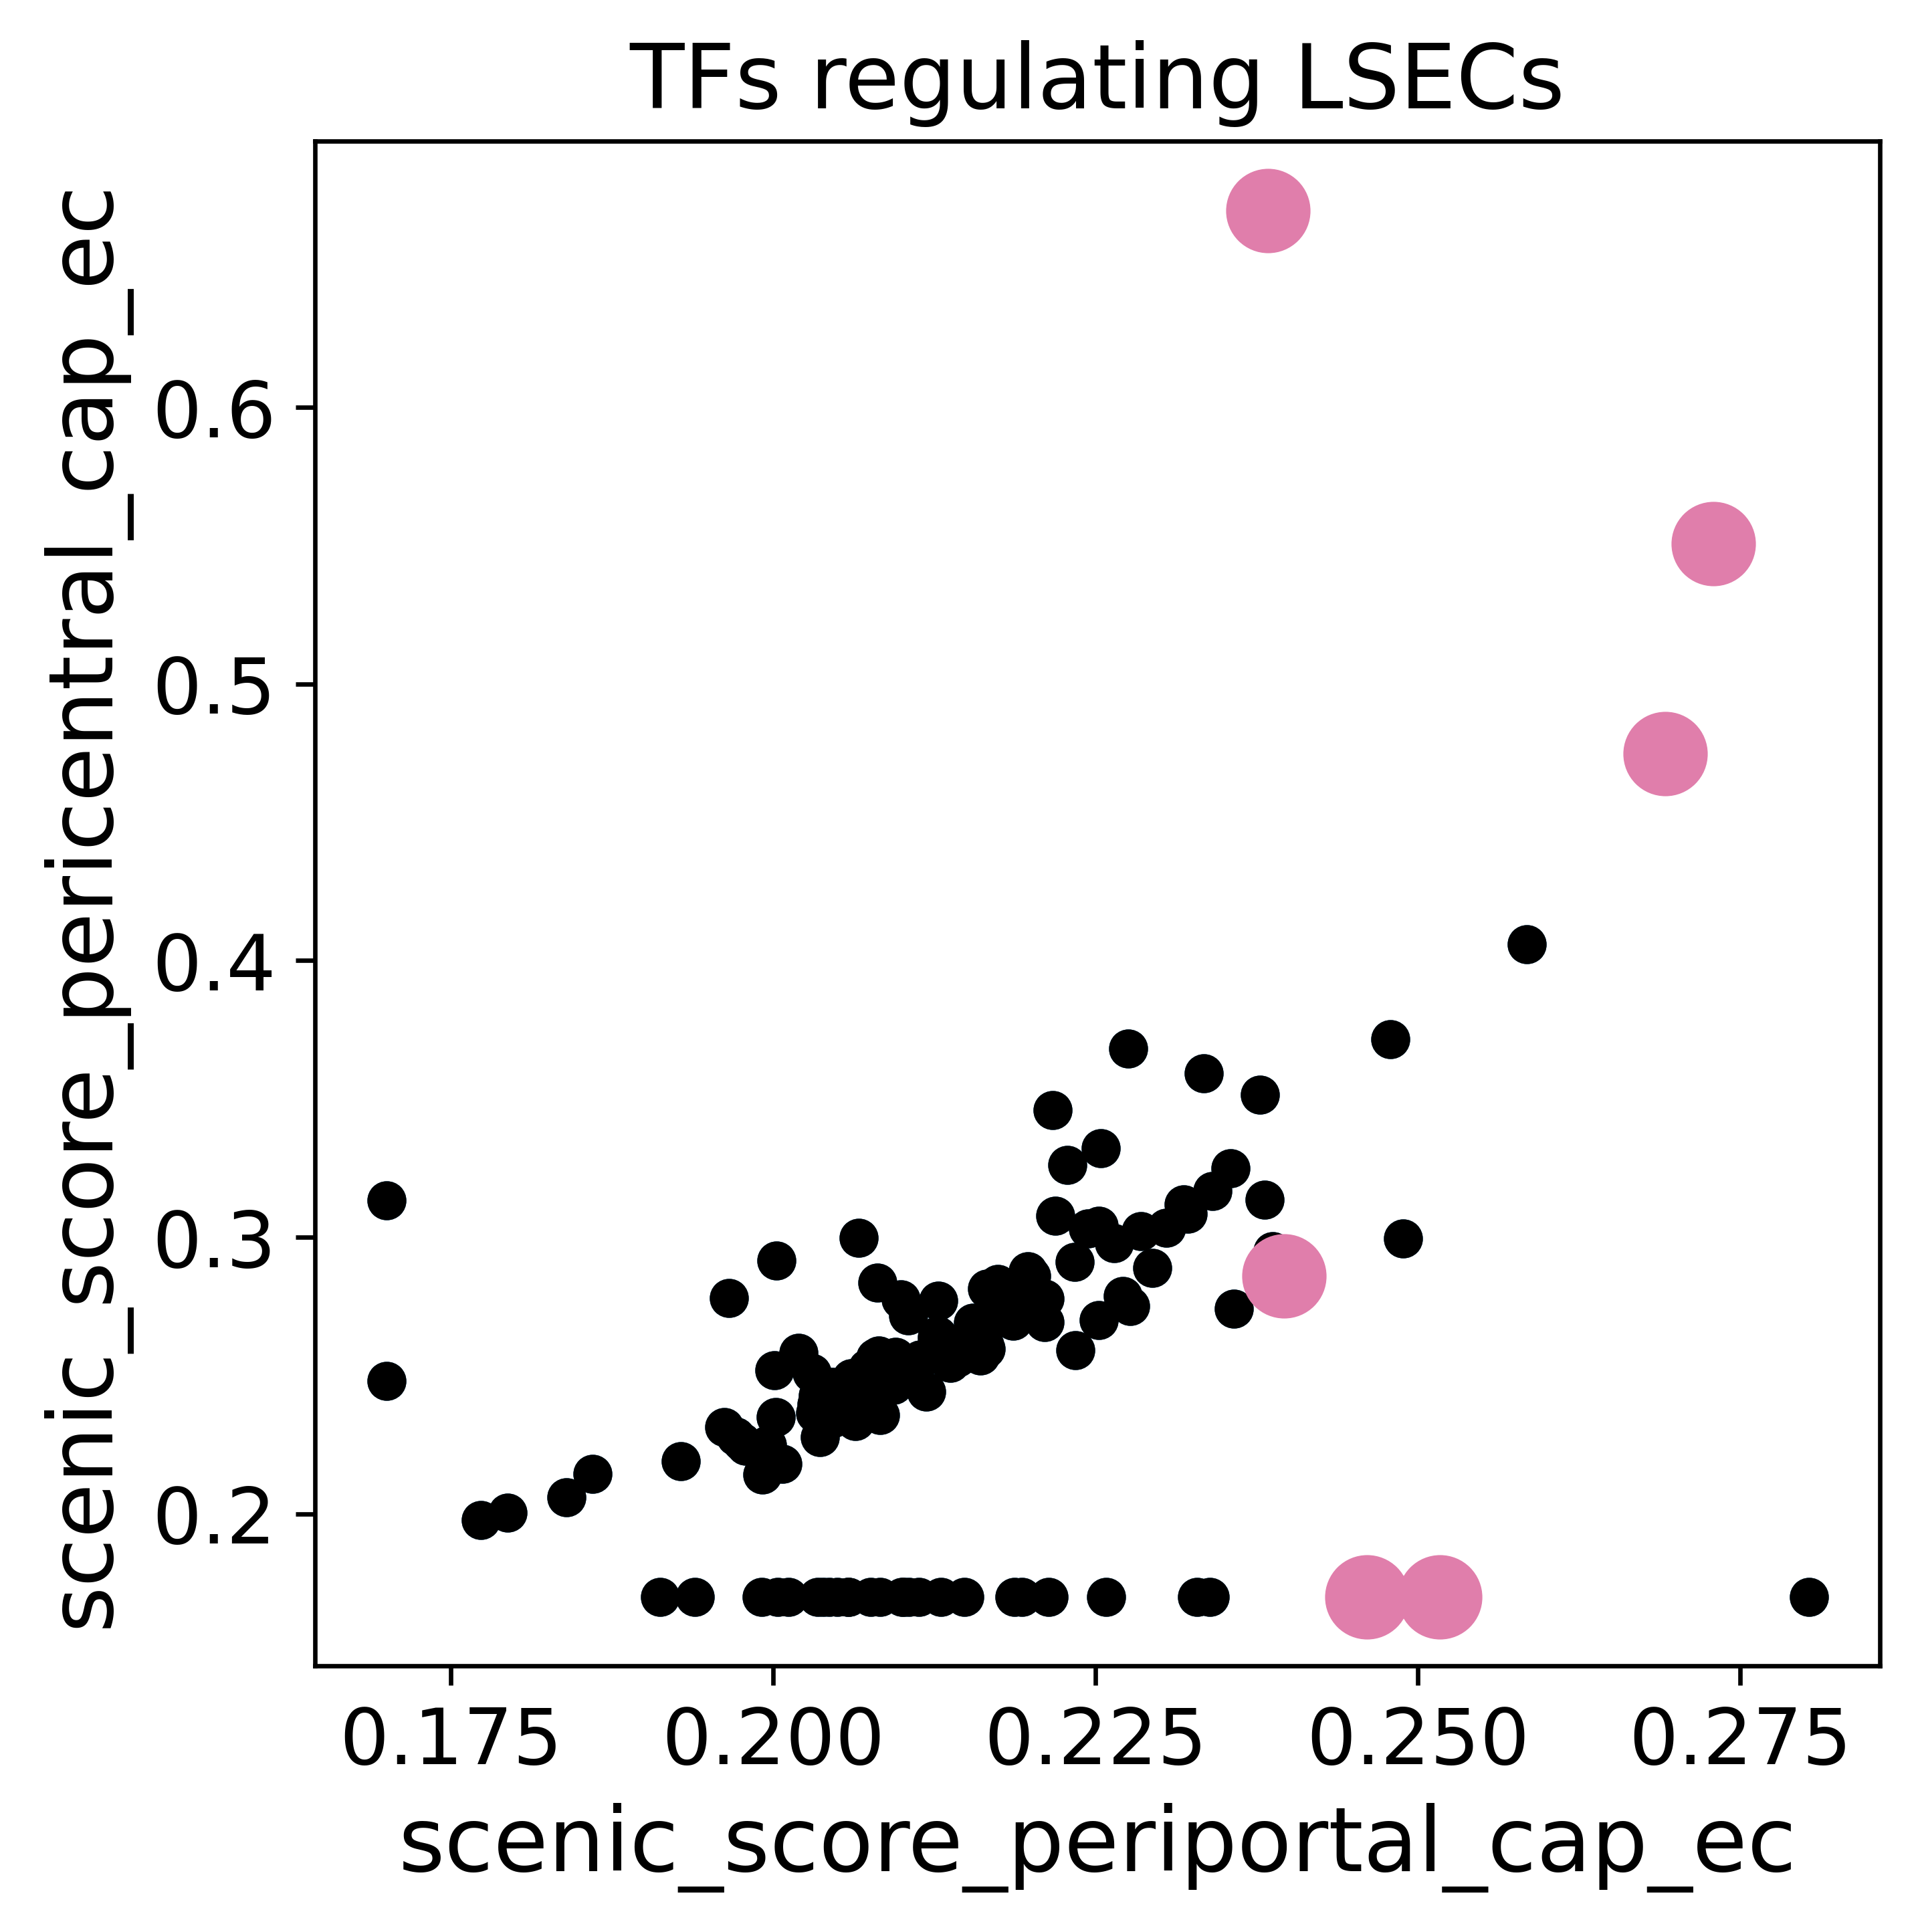

In [92]:
plt.figure(figsize =(5,5), dpi = 300)
plt.scatter(rss_LSEC['periportal_cap_ec_y'], rss_LSEC['pericentral_cap_ec_x'])

# Black
plt.scatter(rss_LSEC['periportal_cap_ec_y'], rss_LSEC['pericentral_cap_ec_x'], color='black')

# Gray
gray_condition = (rss_LSEC['pericentral_cap_ec_x'] == 0) | (rss_LSEC['periportal_cap_ec_y'] == 0)
gray_data = rss_LSEC[gray_condition]
plt.scatter(gray_data['periportal_cap_ec_y'], gray_data['pericentral_cap_ec_x'], color='gray')

# pc
highlighted_pc = rss_LSEC.loc[rss_LSEC.index.isin(highlighted_pc_index)]
plt.scatter(highlighted_pc['periportal_cap_ec_y'], highlighted_pc['pericentral_cap_ec_x'], 
            color='#e07eab', s = 200
)

# pp
highlighted_pp = rss_LSEC.loc[rss_LSEC.index.isin(highlighted_pp_index)]
plt.scatter(highlighted_pp['periportal_cap_ec_y'], highlighted_pp['pericentral_cap_ec_x'], 
            color='#e07eab', s = 200
)

# GATA4
highlighted_lsec = rss_LSEC.loc[rss_LSEC.index.isin(highlighted_lsec_index)]
plt.scatter(highlighted_lsec['periportal_cap_ec_y'], highlighted_lsec['pericentral_cap_ec_x'], 
            color='#e07eab', s = 200
)

# Add labels, legend, and other plot customizations

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 0.6)
#plt.ylim(0, 0.6)


plt.xlabel('scenic_score_periportal_cap_ec', fontsize = 16)
plt.ylabel('scenic_score_pericentral_cap_ec', fontsize = 16)

plt.title('TFs regulating LSECs', fontsize = 16)
plt.grid(False)

# Show the plot
plt.savefig('./figures/scatter_LSEC_raw_score.png', bbox_inches='tight', pad_inches=0.2)
plt.show()

In [97]:
rss_LSEC.to_csv('lsec_normalised.csv')

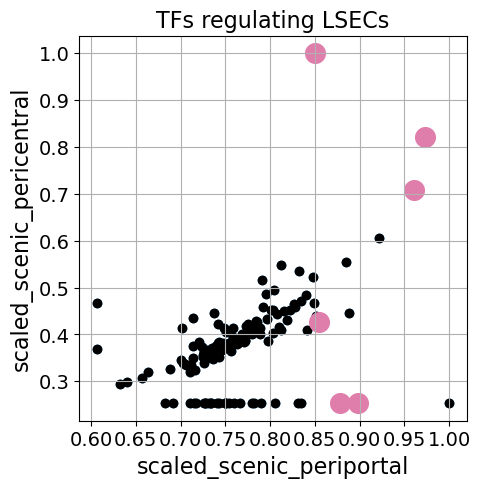

In [ ]:
plt.figure(figsize =(5,5))
plt.scatter(rss_LSEC['periportal_norm'], rss_LSEC['pericentral_norm'])

# Black
plt.scatter(rss_LSEC['periportal_norm'], rss_LSEC['pericentral_norm'], color='black')

# Gray
gray_condition = (rss_LSEC['pericentral_norm'] == 0) | (rss_LSEC['periportal_norm'] == 0)
gray_data = rss_LSEC[gray_condition]
plt.scatter(gray_data['periportal_norm'], gray_data['pericentral_norm'], color='gray')

# pc
highlighted_pc = rss_LSEC.loc[rss_LSEC.index.isin(highlighted_pc_index)]
plt.scatter(highlighted_pc['periportal_norm'], highlighted_pc['pericentral_norm'], 
            color='#e07eab', s = 200
)

# pp
highlighted_pp = rss_LSEC.loc[rss_LSEC.index.isin(highlighted_pp_index)]
plt.scatter(highlighted_pp['periportal_norm'], highlighted_pp['pericentral_norm'], 
            color='#a85cac', s = 200
)

# GATA4
highlighted_lsec = rss_LSEC.loc[rss_LSEC.index.isin(highlighted_lsec_index)]
plt.scatter(highlighted_lsec['periportal_norm'], highlighted_lsec['pericentral_norm'], 
            color='#FF5733', s = 200
)

# Add labels, legend, and other plot customizations

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('scaled_scenic_periportal', fontsize = 16)
plt.ylabel('scaled_scenic_pericentral', fontsize = 16)

plt.title('TFs regulating LSECs', fontsize = 16)
plt.grid(True)

# Show the plot
plt.savefig('./figures/scatter_LSEC_scale.png', bbox_inches='tight', pad_inches=0.2)
plt.show()

In [7]:
ad = ad[ad.obs['scenic_compartment'].isin(['capillary_ec'])]

In [8]:
ad.obs['ann_vas_scenic']

ctrl12_ATTCCTACAGGGCTTC-0                                            blood_brain_barrier_ec
ctrl12_TTCAGGAGTTGGGTTT-0                                            blood_brain_barrier_ec
ctrl12_CTAGACAGTTGCTAGT-0                                            blood_brain_barrier_ec
ctrl12_GTTGTAGAGGTTCATC-0                                            blood_brain_barrier_ec
ctrl12_GAAACCTCATCCCACT-0                                            blood_brain_barrier_ec
                                                                              ...          
GGAGGTAGTGCGTTTA_TSP9_Pancreas_exocrine_10X_1_1_CellCountTotal-35                    cap_ec
TGGTACAAGCACTCGC_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive-35                     cap_ec
AACCAACGTTCTCCCA_TSP9_Pancreas_exocrine_10X_1_1_CellCountTotal-35                    cap_ec
CAAAGAAAGCGGTATG_TSP9_Pancreas_exocrine_10X_1_1_CellCountLive-35                     cap_ec
ACTACGACAGCGATTT_TSP9_Pancreas_exocrine_10X_1_1_CellCountTotal-35               

In [9]:
# Display unique categories
ad.obs['ann_vas_scenic'].unique()

['blood_brain_barrier_ec', 'myo_cap_ec', 'cap_ec', 'adip_cap_ec', 'kidney_cap_ec', ..., 'periportal_cap_ec', 'endometrium_cap_ec', 'aerocyte_ec', 'pericentral_cap_ec', 'glomeruli_ec']
Length: 12
Categories (12, object): ['adip_cap_ec', 'aerocyte_ec', 'blood_brain_barrier_ec', 'cap_ec', ..., 'pericentral_cap_ec', 'periportal_cap_ec', 'pul_cap_ec', 'pul_tip_cap_ec']

In [10]:
import pandas as pd
sc.set_figure_params(dpi=300)

# Define the desired order of categories
desired_order = ['cap_ec', 'aerocyte_ec', 'pul_cap_ec', 'pul_tip_cap_ec', 'periportal_cap_ec', 'pericentral_cap_ec', 
                'kidney_cap_ec', 'glomeruli_ec', 'endometrium_cap_ec', 'myo_cap_ec', 'adip_cap_ec', 'blood_brain_barrier_ec']  # replace with your actual category names

# Reorder categories
ad.obs['ann_vas_scenic'].cat.reorder_categories(desired_order, inplace=True)

# Display the reordered categories
print(ad.obs['ann_vas_scenic'].cat.categories)


Index(['cap_ec', 'aerocyte_ec', 'pul_cap_ec', 'pul_tip_cap_ec',
       'periportal_cap_ec', 'pericentral_cap_ec', 'kidney_cap_ec',
       'glomeruli_ec', 'endometrium_cap_ec', 'myo_cap_ec', 'adip_cap_ec',
       'blood_brain_barrier_ec'],
      dtype='object')


/tmp/ipykernel_162600/4043477106.py:9: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  ad.obs['ann_vas_scenic'].cat.reorder_categories(desired_order, inplace=True)


/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


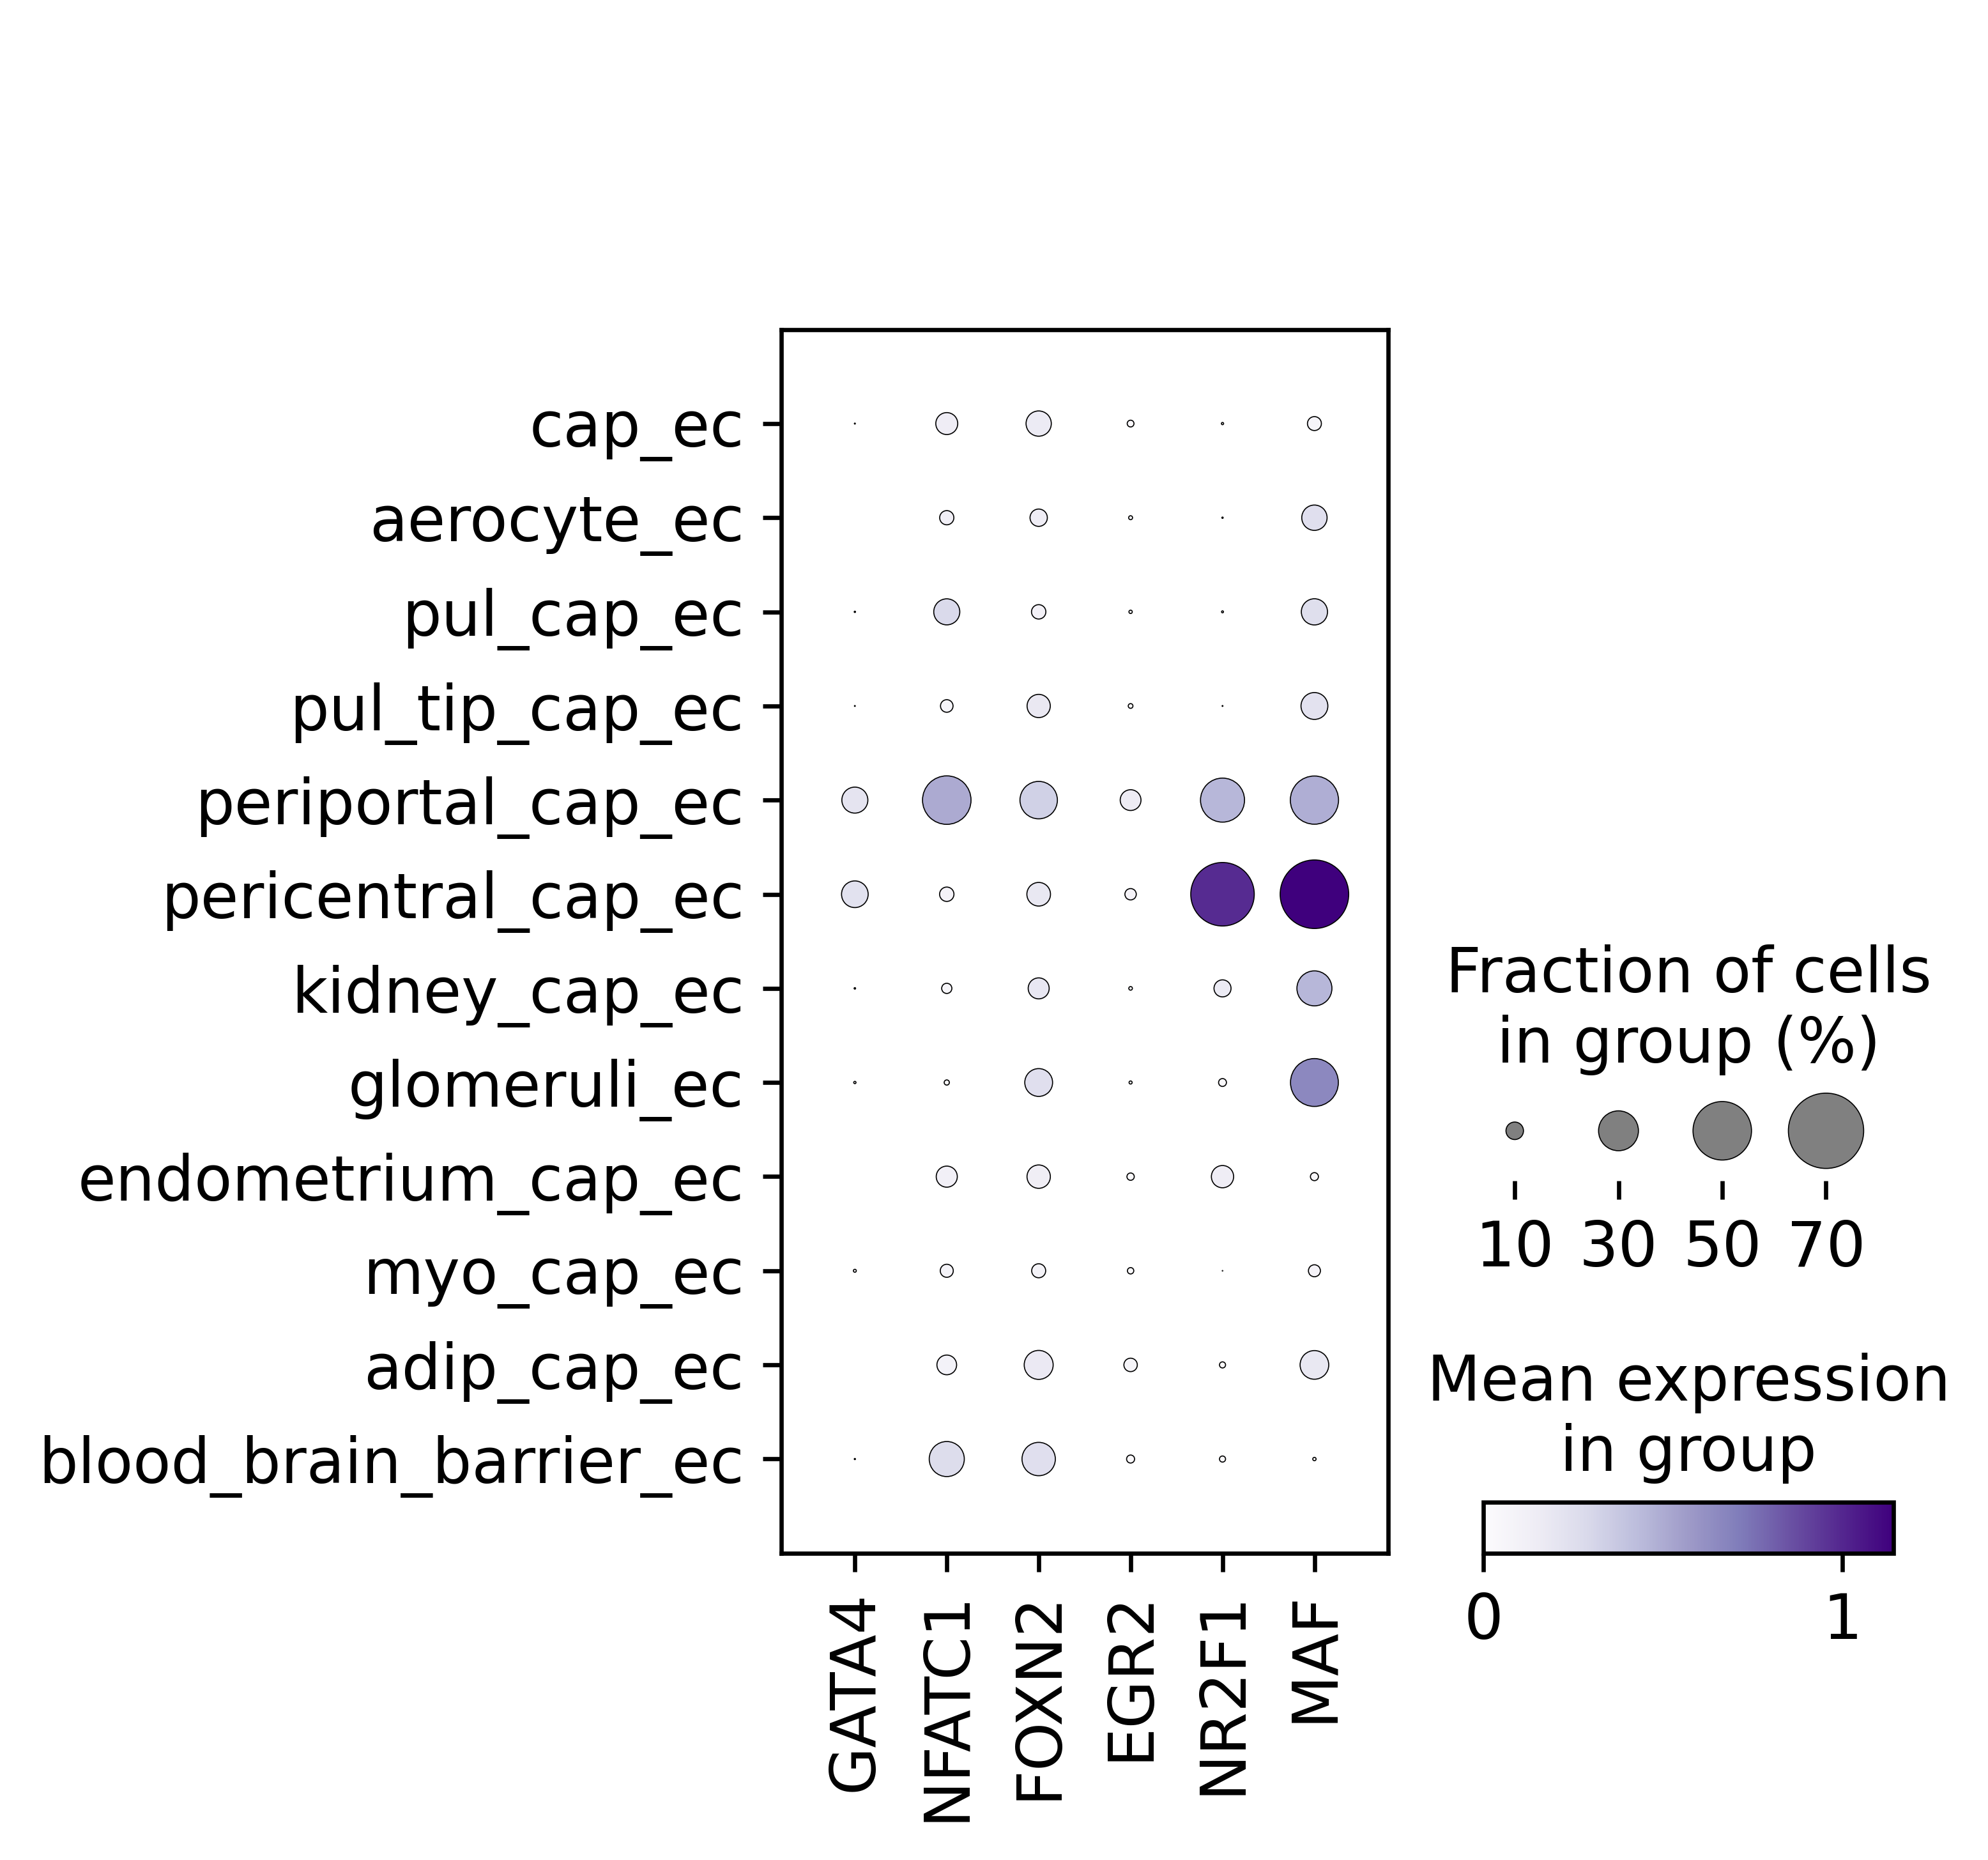

In [11]:
sc.pl.dotplot(ad, 
              var_names=['GATA4', 'NFATC1', 'FOXN2', 'EGR2', 'NR2F1','MAF'], groupby='ann_vas_scenic', dot_min = 0, cmap = "Purples", # swap_axes = True
              save= "LSEC_TFs.png"
             )